In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import math
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from quetzal.model import stepmodel
from quetzal.io import excel

# Preparation of the LoS tables
## Saves LoS attribtute price for cars
## Needs shortest paths of the the road network

In [3]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Create a path for scenario-specific model files
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [5]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [6]:
sm = stepmodel.read_zippedpickles(model_path + 'de_road_los')
z = stepmodel.read_json(model_path + 'de_zones')
sm.zones = z.zones

car_los: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


In [7]:
# Scale time to hours
if sm.car_los['time'].mean() > 1000:
    sm.car_los['time'] = sm.car_los['time'] / 3600
assert sm.car_los['time'].mean() < 10
sm.car_los['time'].mean()

3.0700848170839223

## Add cost to LoS table

In [8]:
# Data from parameters
parking_cost = params['parking_cost']
car_occ = params['car_occ']
urb_dict = sm.zones['urbanisation'].to_dict()
urb_dict = {str(key): val for key, val in urb_dict.items()}
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]

In [9]:
for seg in segments:
    sm.car_los[seg+'_price'] = (sm.car_los['length']/1000 * params['car_var_cost'][seg]
                                + sm.car_los['destination'].map(urb_dict).astype(int).map(parking_cost)
                               ) / car_occ[seg] \
                               + params['car_fix_cost'][seg] * sm.car_los['time']

In [10]:
sm.car_los.sample(2)

,origin,destination,time,link_path,access_time,in_vehicle_time,length,route_type,route_types,commuting_no_car_price,...,business_no_car_price,business_car_price,education_no_car_price,education_car_price,buy/execute_no_car_price,buy/execute_car_price,leisure_no_car_price,leisure_car_price,accompany_no_car_price,accompany_car_price
168893,145220300,84265008,4.559722,"[rl_105984, rl_105770, rl_105949, rl_105576, r...",300,16115,507631,car,"(car,)",222.950263,...,236.375068,44.668628,244.485567,31.388766,184.958514,32.623156,146.5673,24.710305,153.494652,21.667618
42240,34610001,96790180,4.484444,"[rl_243516, rl_242962, rl_243119, rl_243296, r...",300,15844,500667,car,"(car,)",219.828068,...,233.068704,44.055836,241.067937,30.958155,182.357514,32.175611,144.492975,24.371314,151.325293,21.370368


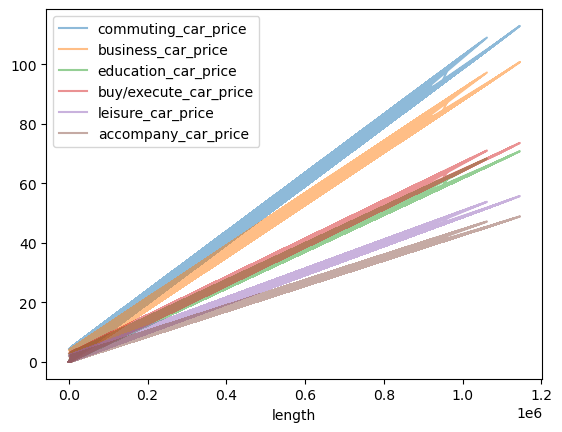

In [11]:
if manual: sm.car_los.set_index('length')[[s+'_price' for s in segments if len(s.split('_'))<3]].plot(alpha=.5)

## Save model

In [12]:
# Make table smaller
cols = ['access_time', 'in_vehicle_time', 'length']
sm.car_los[cols] = sm.car_los[cols].astype(int)

In [13]:
sm.to_zippedpickles(model_path + 'de_road_los', only_attributes=['car_los'])

zones: 100%|█████████████████████████████████████████████████████████████████████████████| 8/8 [00:31<00:00,  3.90s/it]
